## Project Description:

The goal of the project is to build a movie recomender system by trying out multiple variations of content-based methods, collaborative filtering methods (memory-based and model-based) and hybrid methods. The dataset used for the project is the MovieLens latest small dataset.

The project consists of 4 sections:

1. Data Cleaning and Exploration


2. Memory-Based Approach: 

    a. Used tfidf vectorization to process text data, and apply truncated SVD to find the top 200 singular value components
    
    b. Applied both Pearson correlation and Cosine correlation as similarity functions
   
    c. Used user-item similarity and item-item similarity(combining rating and content information)
    
    d. Considered the rating habit of users and tried removing bias from users before computing similarities


3. Model-Based Approach: 

    a. Used the surprise package. Algorithms used in the project includes: NMF, SVD, NormalPredictior, KNN (and also variations of the algorithm)


4. Conclusions

    a. For the Memory-Based Approach, item-item similarity with removed bias model achieved the highest predictability using RMSE as evaluation metrics. For the Model-Based Approach, tuned SVD model has the best performance, using RMSE as evaluation metrics.
    
    b. We're able to predict a user's rating of a movie that he/she has not watched using the model.
    


In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from surprise import Reader, SVD, accuracy,KNNBasic,NormalPredictor, KNNWithZScore, KNNWithMeans, NMF,dataset
from surprise.model_selection import train_test_split,cross_validate,GridSearchCV
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

### Data Cleaning and Exploration

In [3]:
ratings=pd.read_csv("./ml-latest-small/ratings.csv")
movies=pd.read_csv("./ml-latest-small/movies.csv")
tags=pd.read_csv("./ml-latest-small/tags.csv")

In [4]:
ratings['date']=ratings.timestamp.apply(lambda x: datetime.fromtimestamp(x))
ratings['year']=ratings.date.dt.year
ratings['month']=ratings.date.dt.month
ratings['day']=ratings.date.dt.day

In [5]:
ratings.head(5)

,userId,movieId,rating,timestamp,date,year,month,day
0,1,1,4.0,964982703,2000-07-30 11:45:03,2000,7,30
1,1,3,4.0,964981247,2000-07-30 11:20:47,2000,7,30
2,1,6,4.0,964982224,2000-07-30 11:37:04,2000,7,30
3,1,47,5.0,964983815,2000-07-30 12:03:35,2000,7,30
4,1,50,5.0,964982931,2000-07-30 11:48:51,2000,7,30


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 8 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
date         100836 non-null datetime64[ns]
year         100836 non-null int64
month        100836 non-null int64
day          100836 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(6)
memory usage: 6.2 MB


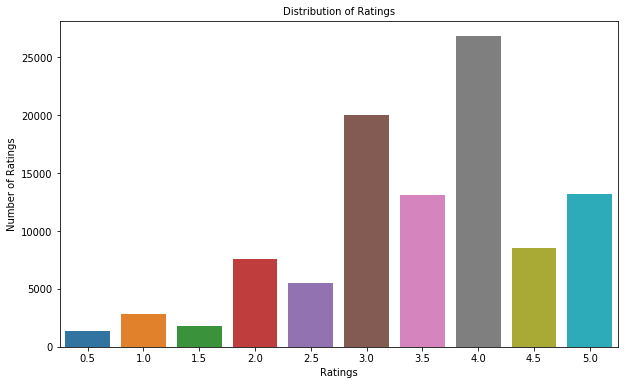

In [7]:
plt.figure(figsize = (10, 6))
ax = sns.countplot(x="rating", data=ratings)
plt.title("Distribution of Ratings", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

Text(0.5, 0, 'Number of Ratings by Users')

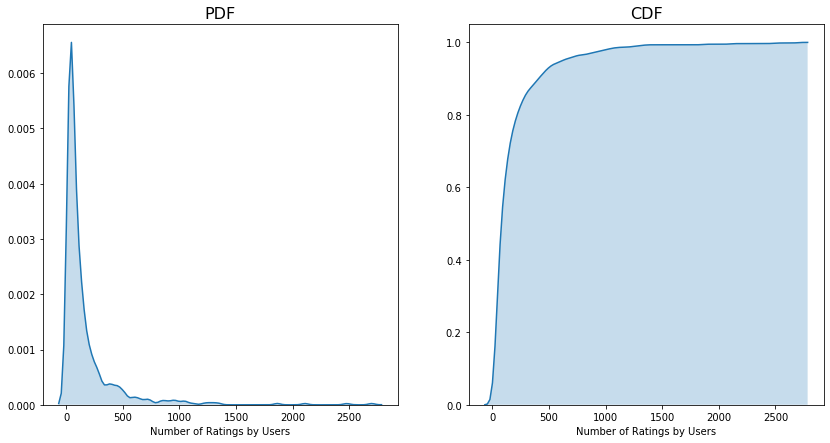

In [8]:
ratings_per_user=ratings.groupby('userId')['rating'].count()
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))
sns.kdeplot(ratings_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 16)
axes[0].set_xlabel("Number of Ratings by Users", fontsize = 10)
sns.kdeplot(ratings_per_user.values, shade = True, ax = axes[1], cumulative=True)
axes[1].set_title("CDF", fontsize = 16)
axes[1].set_xlabel("Number of Ratings by Users", fontsize = 10)

Text(0.5, 0, 'Mean Ratings by Users')

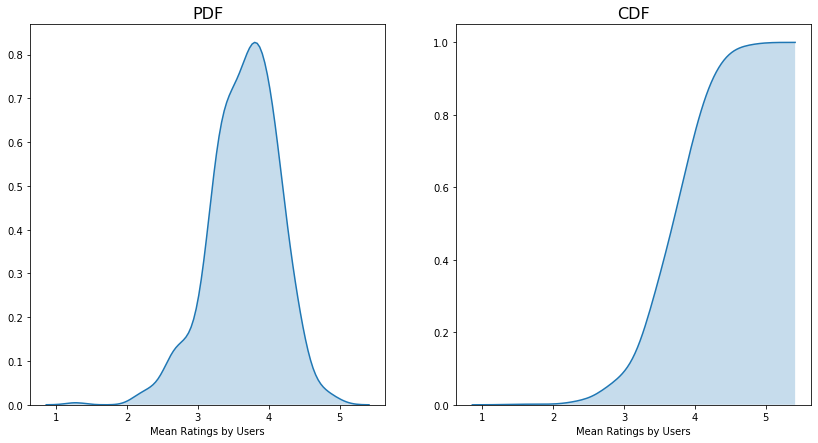

In [9]:
ratings_per_user=ratings.groupby('userId')['rating'].mean()
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))
sns.kdeplot(ratings_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 16)
axes[0].set_xlabel("Mean Ratings by Users", fontsize = 10)
sns.kdeplot(ratings_per_user.values, shade = True, ax = axes[1], cumulative=True)
axes[1].set_title("CDF", fontsize = 16)
axes[1].set_xlabel("Mean Ratings by Users", fontsize = 10)

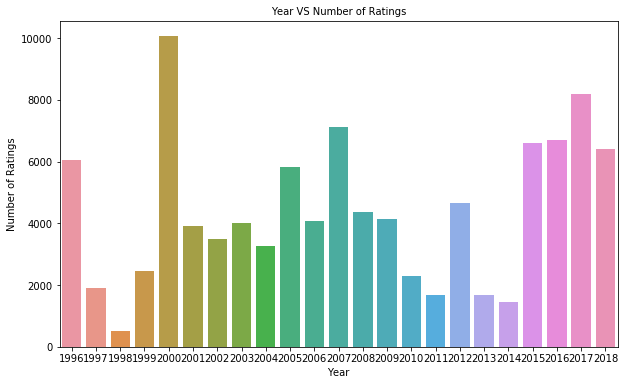

In [10]:
fig = plt.figure(figsize = (10, 6))
axes = sns.countplot(x = "year", data = ratings)
axes.set_title("Year VS Number of Ratings", fontsize = 10)
axes.set_xlabel("Year", fontsize = 10)
axes.set_ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [11]:
#ratings.userId.unique()

In [12]:
#remove the '|' signs in the genres column
movies['genres']=movies.genres.apply(lambda x: ' '.join(x.split('|')))
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [13]:
tags.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [14]:
#remove rows with duplicated titles, keep the rows with more genres information
title=movies.title
dup_movies=movies[title.isin(title[title.duplicated()])]
dup_movies['genres_info']=dup_movies['genres'].apply(lambda x: len(x))
index_to_delete=dup_movies.sort_values('genres_info').drop_duplicates(subset='title',keep='last').index
movies=movies.drop(movies.index[index_to_delete])                                                                             

/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
#print(movies.head(5))

In [18]:
#only keep the movies with ratings
movie_with_rating = ratings.movieId.unique().tolist()
movies=movies[movies.movieId.isin(movie_with_rating)]
#print(movies.head(5))

In [19]:
#merge tags and movies
mixed=pd.merge(movies, tags, on='movieId')
#print(mixed.head(5))

In [20]:
mixed.fillna("", inplace=True)

In [21]:
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))

In [22]:
merged=pd.merge(movies, mixed, on='movieId', how='left')

In [23]:
merged.fillna("", inplace=True)
merged['metadata']= merged[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)

In [24]:
merged.head()

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar pixar fun,pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy magic board game Robin Williams game,fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),Comedy Romance,moldy old,moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance,,Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy,pregnancy remake,pregnancy remake Comedy


In [25]:
ratings_merged = pd.merge(ratings, merged, on="movieId", how="right")
ratings_merged=ratings_merged.drop(['timestamp','tag','genres'],axis=1)
#print(ratings_merged.head())

In [26]:
#since each user has at least 20 ratings, we assign 10 ratings of each user into the test set to 
#aviod coldstart problem
for u in ratings_merged.userId.unique():
    sampled_index=np.random.choice(ratings_merged.loc[ratings_merged.userId==u].index,size=10,replace=False)
    ratings_merged.loc[sampled_index, 'for_testing']=True

In [27]:
ratings_merged_test=ratings_merged.loc[ratings_merged.for_testing==True].drop(['for_testing'],axis=1)
ratings_merged_train=ratings_merged.loc[ratings_merged.for_testing!=True].drop(['for_testing'],axis=1)

In [28]:
print(ratings_merged_train.shape)
print(ratings_merged_test.shape)

(94650, 9)
(6100, 9)


In [29]:
#ratings_merged.userId.unique()

### Preprocess Content Text Data

In [30]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(merged['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=merged.index.tolist())

In [31]:
print(tfidf_df.shape) #9719 movies, 1675 words

(9719, 1675)


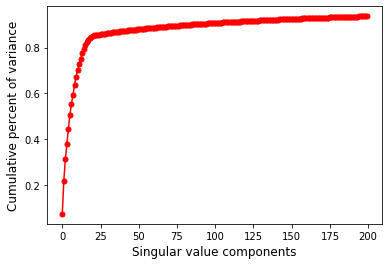

In [32]:
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
Content_df=pd.DataFrame(latent_matrix,index=merged.movieId.tolist())
# plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 10, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [33]:
Content_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
1,0.102107,0.082956,0.069229,0.079745,-0.158802,0.011390,0.235963,-0.009387,-0.121844,-0.007525,...,-0.001967,-0.128563,0.069602,0.032762,-0.083891,0.072998,-0.045668,0.062033,0.042836,-0.005996
2,0.032450,0.008864,0.058775,0.083457,-0.113247,0.007123,0.189148,-0.006309,-0.075070,0.002374,...,0.002537,0.003017,0.006074,0.012922,-0.008475,0.003715,0.009158,0.008716,0.025791,-0.006143
3,0.148064,0.105223,-0.043041,0.129085,0.089120,-0.037231,-0.011774,0.000641,0.004546,-0.002366,...,-0.001943,0.006762,0.007687,-0.004749,0.005577,-0.003202,0.002385,0.001646,-0.003208,-0.004366
4,0.826075,0.065578,-0.292478,0.395828,0.244665,-0.074421,-0.045554,-0.000910,0.027451,-0.001068,...,-0.000014,0.000206,-0.000008,-0.000149,0.000041,0.000300,-0.000011,0.000028,-0.000167,-0.000329
5,0.112948,0.121112,-0.006226,-0.037884,-0.004486,0.009883,-0.009168,-0.002307,0.003938,-0.011411,...,0.010998,0.002921,-0.010046,0.012260,-0.011942,0.000648,-0.008091,-0.005696,0.000334,-0.021824


In [34]:
a_1 = np.array(Content_df.loc[Content_df.index==1]).reshape(1,-1)
a_1.shape
b_1 = np.array(Content_df.loc[Content_df.index!=1])
b_1.shape
score_1 = cosine_similarity(b_1, a_1)
print(score_1.shape)

(9718, 1)


### User-Item Filtering and Item-Item Filtering; Collaborative and Hybrid method

In [36]:
mean_rating=ratings_merged_train['rating'].mean()

In [37]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [38]:
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation """
    
    ids_to_estimate = zip(ratings_merged_test.userId, ratings_merged_test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = ratings_merged_test.rating.values
    return compute_rmse(estimated, real)

In [39]:
def overall_mean(userId, movieId):
    return mean_rating

print('RMSE for estimate: %s' % evaluate(overall_mean))

RMSE for estimate: 1.0605546006853537


In [40]:
def content_mean(userId, movieId):
    """ The user's rating for other movies, use the mean of the user's movies ratings, excluding the current movie"""
    
    user_condition = ratings_merged_train.userId == userId
    movie_condition=ratings_merged_train.movieId != movieId
    rating_for_others=ratings_merged_train.loc[user_condition & movie_condition]
    if rating_for_others.empty:
        return mean_rating
    else:
        return rating_for_others.rating.mean()

print('RMSE for estimate: %s' % evaluate(content_mean))

RMSE for estimate: 0.9630920842598631


In [41]:
def collab_mean(userId, movieId):
    """ The movie's rating by other users, use the mean of the movie's rating by users, excluding the current user"""
    
    user_condition=ratings_merged_train.userId != userId
    movie_condition=ratings_merged_train.movieId == movieId
    rating_by_others=ratings_merged_train.loc[user_condition & movie_condition]
    if rating_by_others.empty:
        return mean_rating
    else:
        return rating_by_others.rating.mean()

print('RMSE for estimate: %s' % evaluate(collab_mean))

RMSE for estimate: 1.00123936250464


- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

In [42]:
def pearson(s1, s2,epsilon=1e-9):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return (np.sum(s1_c * s2_c)+epsilon) / (np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))+epsilon)

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [43]:
def cosine(s1, s2,epsilon=1e-9):
    """Take two pd.Series objects and return their cosine similarity."""
    return (np.sum(s1 * s2)+epsilon) / (np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))+epsilon)

In [44]:
user_pivot = ratings_merged.pivot_table('rating', index='movieId', columns='userId')
movie_pivot = ratings_merged.pivot_table('rating', index='userId', columns='movieId')

In [45]:
ratings_merged['mean_ratings']=ratings_merged.groupby(['userId'])['rating'].transform('mean')
#remove bias of individual user. Some user tend to give higher ratings, others tend to give lower ratings.
ratings_merged['rmbias_ratings']=ratings_merged.rating-ratings_merged.mean_ratings  
user_pivot_rmbias = ratings_merged.pivot_table('rmbias_ratings', index='movieId', columns='userId')

In [46]:
#calculate matrix sparsity
na_entries=sum(user_pivot.isna().sum())
total_entries=user_pivot.shape[0]*user_pivot.shape[1]
sparsity=na_entries/total_entries
print(sparsity)

0.9830060773303602


In [47]:
#User-item Collaborative Filtering using Pearson Correlation
def collab_pearson(userId,movieId):
    
    user_condition = ratings_merged_train.userId != userId 
    movie_condition = ratings_merged_train.movieId == movieId
    ratings_by_others = ratings_merged_train.loc[user_condition & movie_condition] 
    if ratings_by_others.empty: 
        return mean_rating

    ratings_by_others.set_index('userId', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = user_pivot[their_ids]
    user_profile = user_pivot[userId]
    sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims= ratings_sims.sort_values(by=['sim'], ascending=False).head(10) #higher rmse
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)

print('RMSE for CollabSim: %s' % evaluate(collab_pearson))

RMSE for CollabSim: 0.8852489763313234


In [48]:
collab_pearson(1,1)

3.843564977489461

In [49]:
#User-item Collaborative Filtering using Cosine Correlation
def collab_cosine(userId,movieId):
    
    user_condition = ratings_merged_train.userId != userId 
    movie_condition = ratings_merged_train.movieId == movieId
    ratings_by_others = ratings_merged_train.loc[user_condition & movie_condition] 
    if ratings_by_others.empty: 
        return mean_rating

    ratings_by_others.set_index('userId', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_profiles = user_pivot[their_ids]
    user_profile = user_pivot[userId]
    sims = their_profiles.apply(lambda profile: cosine(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
    #ratings_sims= ratings_sims.sort_values(by=['sim'], ascending=False).head(10) #higher rmse
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim)

print('RMSE for Collab_cosine: %s' % evaluate(collab_cosine))

RMSE for Collab_cosine: 0.9872746267307068


In [50]:
collab_cosine(1,1)

3.900591166945928

In [51]:
def collab_sim_rmbias(userId,movieId):
    
    ratings_mean=ratings_merged_train.groupby(['userId'])['rating'].mean()
    user_mean=ratings_mean[userId]

    user_condition = ratings_merged_train.userId != userId
    movie_condition = ratings_merged_train.movieId == movieId
    ratings_by_others = ratings_merged_train.loc[user_condition & movie_condition] 
    if ratings_by_others.empty: 
        return mean_rating

    ratings_by_others.set_index('userId', inplace=True)
    their_ids = ratings_by_others.index
    their_ratings = ratings_by_others.rating
    their_ratings_mean=ratings_mean.loc[ratings_mean.index.isin(their_ids)]
    their_ratings_rmbs=their_ratings-their_ratings_mean
    
    their_profiles = user_pivot[their_ids]
    user_profile = user_pivot[userId]
    sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim': sims, 'rating_rmbias': their_ratings_rmbs})
    ratings_sims = ratings_sims[ratings_sims.sim > 0]
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        
        return np.average(ratings_sims.rating_rmbias, weights=ratings_sims.sim)+user_mean

print('RMSE for collab_sim_rmbias: %s' % evaluate(collab_sim_rmbias))

RMSE for collab_sim_rmbias: 0.8017667931353997


In [53]:
collab_sim_rmbias(1,1)

4.624400056034571

In [54]:
#Movie similarity based on ratings and content
#cosine similarity function
def movie_hybrid_sim(userId, movieId):
    """ Ratings weighted by correlation similarity. """

    user_condition = ratings_merged_train.userId == userId
    movie_condition = ratings_merged_train.movieId != movieId
    ratings_for_others = ratings_merged_train.loc[user_condition & movie_condition]
    if ratings_for_others.empty: 
        return mean_rating
    
    ratings_for_others.set_index('movieId', inplace=True)
    their_ids = ratings_for_others.index
    their_ratings = ratings_for_others.rating
    their_profiles = movie_pivot[their_ids]
    movie_profile = movie_pivot[movieId]
    movie_content = np.array(Content_df.loc[Content_df.index==1]).reshape(1,-1)
    their_content = np.array(Content_df.loc[Content_df.index.isin(their_ids)])
    sims_content= cosine_similarity(their_content, movie_content).reshape(-1)
    sims_rating = their_profiles.apply(lambda profile: cosine(profile, movie_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim_content': sims_content,'sim_rating': sims_rating, 'rating': their_ratings})
    ratings_sims['sim_hybrid']=(ratings_sims.sim_content+sims_rating)/2
    ratings_sims = ratings_sims[ratings_sims.sim_hybrid > 0]
    
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim_hybrid)

print('RMSE for movie_hybrid_sim: %s' % evaluate(movie_hybrid_sim))

RMSE for movie_hybrid_sim: 0.9376498547690458


In [55]:
#Movie similarity based on ratings and content
#pearson similarity function
def movie_hybrid_sim(userId, movieId):
    """ Ratings weighted by correlation similarity. """

    user_condition = ratings_merged_train.userId == userId
    movie_condition = ratings_merged_train.movieId != movieId
    ratings_for_others = ratings_merged_train.loc[user_condition & movie_condition]
    if ratings_for_others.empty: 
        return mean_rating
    
    ratings_for_others.set_index('movieId', inplace=True)
    their_ids = ratings_for_others.index
    their_ratings = ratings_for_others.rating
    their_profiles = movie_pivot[their_ids]
    movie_profile = movie_pivot[movieId]
    movie_content = np.array(Content_df.loc[Content_df.index==1]).reshape(1,-1)
    their_content = np.array(Content_df.loc[Content_df.index.isin(their_ids)])
    sims_content= cosine_similarity(their_content, movie_content).reshape(-1)
    sims_rating = their_profiles.apply(lambda profile: pearson(profile, movie_profile), axis=0)
    ratings_sims = pd.DataFrame({'sim_content': sims_content,'sim_rating': sims_rating, 'rating': their_ratings})
    ratings_sims['sim_hybrid']=(ratings_sims.sim_content+sims_rating)/2
    ratings_sims = ratings_sims[ratings_sims.sim_hybrid > 0]
    
    if ratings_sims.empty:
        return their_ratings.mean()
    else:
        return np.average(ratings_sims.rating, weights=ratings_sims.sim_hybrid)

print('RMSE for movie_hybrid_sim: %s' % evaluate(movie_hybrid_sim))

RMSE for movie_hybrid_sim: 0.8509997768502541


### Model-Based Collaborative Filtering

The idea behind Matrix Factorization is that attitudes or preferences of a user can be determined by a small number of hidden factors. We can call these factors as Embeddings. For SVD or PCA, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices.The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination.

In [56]:
mapping = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [60]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(0.5, 5.0))
data = dataset.Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)
print(data)

In [61]:
trainset, testset = train_test_split(data, test_size=.25)

In [66]:
#baseline model
random = NormalPredictor()
random.fit(trainset)
predictions_random=random.test(testset)
print(accuracy.rmse(predictions_random))

RMSE: 1.4362
1.4362238690825286


In [62]:
nmf = NMF()
nmf.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9290


0.9290438084331856

In [69]:
svd=SVD()
svd.fit(trainset)
predictions_svd=svd.test(testset)
print(accuracy.rmse(predictions_svd))

RMSE: 0.8756
0.875613421633401


In [64]:
#tune svd model
param_grid = {'n_factors': [50,100,150],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
params = gs.best_params['rmse']
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'])

In [65]:
svdtuned.fit(trainset)
predictions_svdt=svdtuned.test(testset)
print(accuracy.rmse(predictions_svdt))

RMSE: 0.8572
0.8572459386900263
RMSE: 0.8739
0.8739268506413796


In [70]:
knn_basic =KNNBasic()
knn_basic.fit(trainset)
predictions = knn_basic.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9503


0.9502982350503191

In [71]:
knn_mean =KNNWithMeans()
knn_mean.fit(trainset)
predictions = knn_mean.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8980


0.8980456103515789

In [72]:
knn_zs =KNNWithZScore()
knn_zs.fit(trainset)
predictions = knn_zs.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8976


0.897612159410451

In [77]:
#tune KNNWithZScore model
sim_options = {'name': 'cosine','user_based': 'True'}
param_grid = {'k': [15, 20, 25, 30, 40, 50, 60]}
gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse','mae'], cv=3)
gs.fit(data)
params = gs.best_params['rmse']
knnzstuned = KNNWithZScore(k=params['k'],measures='rmse')
knnzstuned.fit(trainset)
predictions_knnzs=knnzstuned.test(testset)
print(accuracy.rmse(predictions_knnzs))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

Tuned SVD is the best performing model. Use it to make predictions for user 1 and find the top 10 movies that user 1
haven't watched but would enjoy.

In [75]:
def pred_user_rating(ui,algo):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist() #list of movieId the user rated
        d = {k: v for k,v in mapping.items() if not v in ui_list}  #d: dictionary of un-rated movies       
        predictedL = []
        for i, j in d.items():     
            predicted = algo.predict(ui, j) #userId, movieId
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

# check the preferences of a particular user
user_id = 1
predicted_ratings = pred_user_rating(user_id,svdtuned)
print(predicted_ratings)

                                                     ratings
movies                                                      
Swept Away (Travolti da un insolito destino nel...  5.000000
Paths of Glory (1957)                               5.000000
Grave of the Fireflies (Hotaru no haka) (1988)      5.000000
Dr. Strangelove or: How I Learned to Stop Worry...  5.000000
Guess Who's Coming to Dinner (1967)                 5.000000
Touch of Evil (1958)                                5.000000
Day of the Doctor, The (2013)                       5.000000
Celebration, The (Festen) (1998)                    5.000000
Casablanca (1942)                                   4.986911
Shawshank Redemption, The (1994)                    4.968614
